<a href="https://colab.research.google.com/github/tanmayyb/screw-detector/blob/main/Yolov3_model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yolov3 Model Train on Nut Dataset

## Data Loading and Basic Functions

In [21]:
#@title Imports
import os
import requests
import random
import json
import numpy as np
from skimage import io
from scipy import ndimage
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import rcParams, gridspec
from matplotlib import patches, transforms as plt_transforms

import pickle
import cv2

rcParams['figure.figsize'] = [16, 6]
rcParams['font.size'] =14
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# @title Choose device
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [3]:
device = set_device()

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [10]:
path = 'content/gdrive/My Drive/screw_dataset/'

### load `imgdict` & `annodict`

In [18]:
#with open( os.path.join(path,'saved_variables', 'annodict.pkl'), 'rb') as fid:
#  annodict  = pickle.load(fid) 

In [19]:
#with open( os.path.join(path,'saved_variables', 'imgdict.pkl'), 'rb') as fid:
#  imgdict  = pickle.load(fid) 

## Load Patches & Labels

In [23]:
path = 'content/gdrive/My Drive/screw_dataset/nut_patch_model'

In [24]:
with open( os.path.join(path, 'preprocessed', 'train_labels.pkl'), 'rb') as fid:
  train_labels = pickle.load(fid)

with open( os.path.join(path, 'preprocessed', 'test_labels.pkl'), 'rb') as fid:
  test_labels = pickle.load(fid)

In [40]:
path = 'content/gdrive/My Drive/screw_dataset/nut_patch_model/preprocessed'

In [72]:
train_img = []
for filename in os.listdir(os.path.join(path, 'train')):
  img = cv2.imread(os.path.join(path,'train', filename))
  if type(img) != None:
    train_img.append(img)

In [77]:
test_img = []
for filename in os.listdir(os.path.join(path, 'test')):
  img = cv2.imread(os.path.join(path,'test', filename))
  if type(img) != None:
    test_img.append(img)

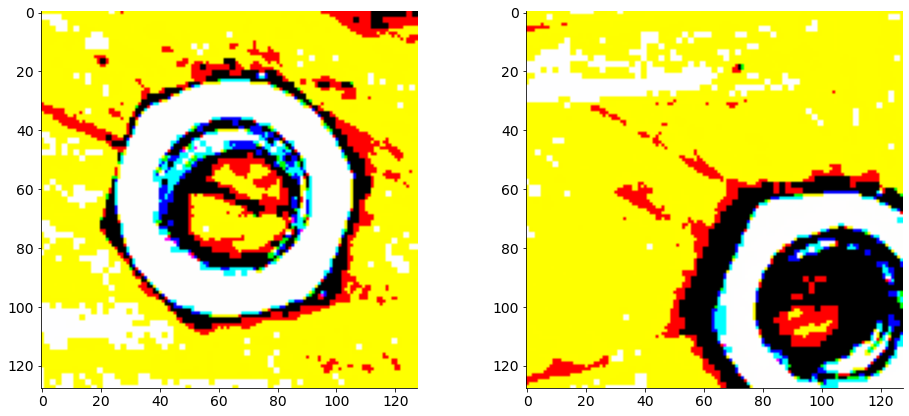

In [80]:
plt.subplot(1,2,1)
plt.imshow(train_img[100]*255)
plt.subplot(1,2,2)
plt.imshow(test_img[0]*255)

## Preprocessing Data

From this training data we preprocess it to make it better for training 

## Training Model

In [ ]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [ ]:
# Images
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

In [ ]:
# Inference
results = model(imgs)

# Results
results.print()
results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)